In [38]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk


In [15]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

In [77]:
class preprocessing():
    def __init__(self, corpus, window_size):
        self.corpus = corpus
        self.window_size = window_size
    
    def split_corpus(self):
        stop_words = stopwords.words("english")
        corpus = self.corpus.split('.')
        train_data = []
        for sentence in corpus:
            sentence = sentence.strip().split()
            sentence = [word.strip(string.punctuation) for word in sentence \
                                                        if word not in stop_words]
            train_data.append(sentence)
        return train_data
    
    def prepare_data_for_training(self):
        sentences = self.split_corpus()
        all_words = []
        for sentence in sentences:
            for word in sentence:
                if word not in all_words:
                    all_words.append(word)
        all_words, V = sorted(all_words), len(all_words)
        data, X_train, y_train = {}, [], []
        for id, word in enumerate(all_words):
            data[word] = id
        for sentence in sentences:
            for id, word in enumerate(sentence):
                center_word, context = np.zeros(V), np.zeros(V)
                center_word[data[word]] = 1
                for i in range(id - self.window_size, id + self.window_size + 1):
                    if i >= 0 and i < len(sentence) and i != id:
                        context[data[sentence[i]]] = 1
                center_word = torch.from_numpy(center_word)
                context = torch.from_numpy(context)
                X_train.append(center_word.float()); y_train.append(context.float())
        return (np.array(X_train), np.array(y_train), all_words)
    

## Prepare data

In [78]:
corpus = "The earth revolves around the sun. The moon revolves around the earth"
preprocess = preprocessing(corpus, window_size = 3)
X_train, y_train, all_words = preprocess.prepare_data_for_training()
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
V = len(X_train[0])

## Model

In [79]:
class network(nn.Module):
    def __init__(self, vocabs_size, hidden_size):
        super(network, self).__init__()
        self.fc1 = nn.Linear(vocabs_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocabs_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    

In [84]:
model = network(vocabs_size = V, hidden_size = 10)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


In [85]:
num_epochs = 2000
history = []

# for i in range(num_epochs):
#     for X, y in zip(X_train, y_train):
#         X_tensor = torch.tensor(X, dtype = torch.float32).unsqueeze(0)
#         y_tensor = torch.tensor(np.argmax(y), dtype = torch.float32).unsqueeze(0)
#         y_pred = model(X_tensor)
#         loss_val = loss(y_pred, y_tensor)
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()
#     if i % 5 == 0:
#         print("Loss value in epoch {} is {}".format(i, loss_val.item()))
#     history.append(loss_val.item())

for epoch in range(num_epochs):
    total_loss = 0
    for X, y in zip(X_train, y_train):
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = loss_fn(output, y_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")
    history.append(total_loss)
    

C:\Users\HH\AppData\Local\Temp\ipykernel_9700\2332054401.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0)
C:\Users\HH\AppData\Local\Temp\ipykernel_9700\2332054401.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)


Epoch 0, Loss: 64.70910310745239
Epoch 20, Loss: 60.154664516448975
Epoch 40, Loss: 58.66490602493286
Epoch 60, Loss: 57.584965229034424
Epoch 80, Loss: 56.69344353675842
Epoch 100, Loss: 55.97877812385559
Epoch 120, Loss: 55.43441390991211
Epoch 140, Loss: 54.995126724243164
Epoch 160, Loss: 54.62014102935791
Epoch 180, Loss: 54.30335783958435
Epoch 200, Loss: 54.046310901641846
Epoch 220, Loss: 53.84427356719971
Epoch 240, Loss: 53.68740797042847
Epoch 260, Loss: 53.565370321273804
Epoch 280, Loss: 53.46958255767822
Epoch 300, Loss: 53.39353942871094
Epoch 320, Loss: 53.33244323730469
Epoch 340, Loss: 53.28277587890625
Epoch 360, Loss: 53.24194812774658
Epoch 380, Loss: 53.20802688598633
Epoch 400, Loss: 53.1795756816864
Epoch 420, Loss: 53.15549564361572
Epoch 440, Loss: 53.134949684143066
Epoch 460, Loss: 53.11728525161743
Epoch 480, Loss: 53.10199522972107
Epoch 500, Loss: 53.08867835998535
Epoch 520, Loss: 53.07700562477112
Epoch 540, Loss: 53.06672286987305
Epoch 560, Loss: 53.0

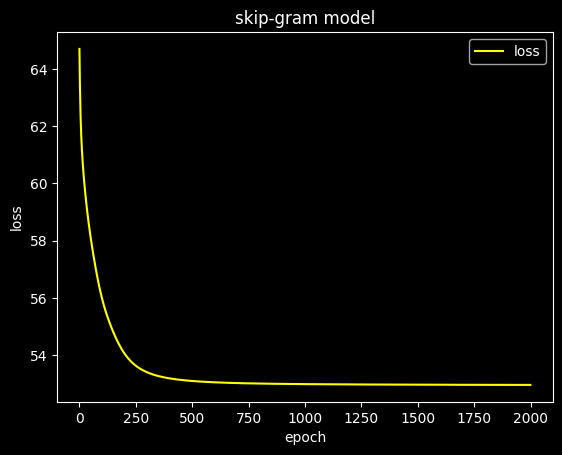

In [86]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.plot(history, c = 'yellow', label = "loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('skip-gram model')
plt.legend()
plt.show()

In [88]:
pred_word = []
window_size = 3
with torch.no_grad():
    for X, y in zip(X_train, y_train):
        context_pred = []
        X_tensor = torch.tensor(X, dtype = torch.float32).unsqueeze(0)
        y_pred = model(X_tensor)
        values, indices = torch.sort(y_pred[0], descending = True)
        for i in indices:
            if i < window_size:
                context_pred.append(all_words[i])
        pred_word.append(context_pred)

C:\Users\HH\AppData\Local\Temp\ipykernel_9700\3237975049.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype = torch.float32).unsqueeze(0)


In [92]:
for i in range(V):
    print([all_words[i]], pred_word[i])

['The'] ['around', 'earth', 'The']
['around'] ['around', 'The', 'earth']
['earth'] ['around', 'earth', 'The']
['moon'] ['earth', 'The', 'around']
['revolves'] ['around', 'earth', 'The']
['sun'] ['around', 'earth', 'The']
